In [1]:
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown

from utils import computation_graph_linear, squared_loss_function

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

assesment_draw_and_fill = True

In [2]:
## generate polinomial features.
def generate_features(x, poly_degree, add_bias = True):
    feat = []
    
    for i in range(poly_degree+1):
        feat.append(x**i)
        
    # remove bias term (ones) if requested 
    if not add_bias:
        feat = feat[1:]
        
    return np.column_stack(tuple(feat))

## generates polinomial data
def generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N, w_true = None, seed = None):
    if seed is not None:
        np.random.seed(seed)
    if w_true is None:
        w_true = np.array([[2],[-1.5],[0.9]])
    x_train = (xmax - xmin) * np.random.random_sample((N,1)) + xmin
    X_feats = generate_features(x_train, poly_degree)
    t_train = computation_graph_linear(X_feats, w_true, b = 0) + np.random.normal(0, noise_var, size=x_train.shape[0])[:,np.newaxis]
    return x_train, t_train

def fit_norm2_least_square(X,T, lam = 0):

    # Obtain optimum model
    XtX = np.transpose(X) @ X
    Xty = np.transpose(X) @ T

    XtX += lam * np.eye(XtX.shape[0])

    # withouth regularization
    w_opt = np.linalg.solve(XtX, Xty)
    
    return w_opt

def norm_data(X, mean = None, std = None ):
    if mean is None:
        mean = np.mean(X, axis = 0)
        std  = np.std(X, axis = 0)

    return  (X - mean) / std, mean, std

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\t}{\mathbf{t}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\T}{\mathbf{T}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\J}{\mathbf{J}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\dd}{\text{d}}
\newcommand{\vec}{\text{vec}}
$$

# Multivariate Regression, Overfitting, Regularization and Cross Validation

This assesment will cover different aspects regarding regularization, overfitting, multivariate regression and cross validation.

To do so we will work with linear models of the form: $f:\mathbb{R} \to \mathbb{R}$ or $f:\mathbb{R}^N \to \mathbb{R}$, which can be naturally expressed by a dot product of the form:

\begin{split}
\y &= \x^T\w = \sum^d_{i=1} x_i \cdot w_i + \cancelto{b}{1\cdot w_0}\\
\end{split}

If we are given $N$ training instances, we know the loss is a sum over all predictions. This assessment will use the square loss:

\begin{split}
L(\w,\X,\t) &= \sum^N_{n=1}(t_n - \x_n^T \cdot \w)^2\\
&= \sum^N_{n=1}(t_n - \sum^d_{i=1} x_{n,i} \cdot w_i + b)^2
\end{split}

Using our conventions we will keep inputs $\x$ in matrices $\X$ which each row containing a data instance and each column its features. Since we only consider regression into the reals we use a column vector $\t$ to represent targets, which each row being the target of each datapoint.

In this case, optimal fitting of the best linear model can be obtained exactly and the solution is given by:

\begin{split}
\w^*=(\X^T\X)^{-1}\X^T\t
\end{split}

Note that, for numerical stability, we should never solve inverses directly. In other words never compute the inverse of a matrix to then multiply. How do we actually do this? Well using cholesky factorizations and forward-backward sustitution algorithm. Happy for you, this is done under the hood by numpy. 

It turns out that we can implicitely compute an inverse by solving a linear system. The solution of the linear system will be, directly, the product of a matrix inverse by other value. Consider the following linear system in which we are intereset in obtaining the value for $\y$.

\begin{split}
\A\y = \b
\end{split}

then, the solution to this system is given by:

\begin{split}
\y = \A^{-1}\b
\end{split}

The forward-backward sustitution algorithm is an algorithm that given a Lower Upper factorization of the matrix $\A$ (such as the cholesky factorization) solves this system. The solution will be directly the product of the inverse by the vector, which is what we want. In our problem we are intersted in getting the product:

\begin{split}
(\X^T\X)^{-1}\X^T
\end{split}

This is the solution of a linear system of the form:

\begin{equation}
(\X^T\X)\y = \X^T
\end{equation}

The numpy function that solves this system is the `np.linalg.solve`: https://numpy.org/doc/2.3/reference/generated/numpy.linalg.solve.html.

With $L_2$ regularization things are similar with optimal parameter given by:

\begin{split}
\w^*=(\X^T\X + \lambda\I)^{-1}\X^T\t
\end{split}

where a $\I$ matrix can be obtained using `np.eye` function.

##### Task: Implement a python function that computes optimal $\w$ given training data. 

The function signature must be:

```python 
def fit_norm2_least_square(X,T, lam = 0):
    ...
    return w_opt
```

When lambda is $0$ no regularization is applied. 

In [3]:
if assesment_draw_and_fill:
    code = """
```python
def fit_norm2_least_square(X,T, lam = 0):

    # Obtain optimum model
    XtX = ... # X^T X 
    Xty = ... # X^T t

    XtX += lam * np.eye(...)

    w_opt = np.linalg.solve(..., ...)
    
    return ...
```
    """
    
    
    display(Markdown(code))


```python
def fit_norm2_least_square(X,T, lam = 0):

    # Obtain optimum model
    XtX = ... # X^T X 
    Xty = ... # X^T t

    XtX += lam * np.eye(...)

    w_opt = np.linalg.solve(..., ...)
    
    return ...
```
    

### Data generation

Let's create functions to create our datasets. In this assesment we will only work with a dataset generated from a polynomial function. For example for a polynomial of order two we can generate a dataset by randomly pick a point $x_i$ in our domain, and then generate $t_i$ through:

\begin{split}
t_i &= w_0 + w_1\cdot x_i + w_2 \cdot x_i^2 + \epsilon;  \epsilon \sim \mathcal{N}(\epsilon\mid 0, \sigma^2_\epsilon)
\end{split}

or in compact form:

\begin{split}
t_i &= \x^T_i\w + \epsilon
\end{split}

with:

\begin{split}
\x = 
\begin{bmatrix}
1\\
x\\
x^2
\end{bmatrix}
\end{split}

To do so let's go through these tasks

##### task:

Create a function that given a column vector $\x$ (np.array with shape (N,1)) creates a matrix with polynomial features of a given degree. So if for example the specified degree is 3, the output of the funciton must be a matrix of shape (N,4) with the first columns containing ones (corresponding to the bias, and the next three columns contains $x$,$x^2$ and $x^3$. The function considers a flag that if true add bias (ie the columns of ones) and if false it does not. Thus, when true the resulting matrix is (N,4) as explained, otherwise is (N,3) omitting the column of ones.

```python
def generate_features(x, poly_degree, add_bias = True):
    # tip, you can use a for loop where the loop iterator is used as the power of the polynomial
    # tip, check numpy.column_stack function.
        
    return X # (N, poly_degree) if add_bias else (N, poly_degree - 1 )
```



In [4]:
if assesment_draw_and_fill:
    code = """
```python
def generate_features(x, poly_degree, add_bias = True):
        
    for i in range():
        feat.append(...)
        
    # remove bias term (ones) if requested 
    if not add_bias:
        feat = feat[...]
        
    return np.column_stack(...)
```
"""
    display(Markdown(code))


```python
def generate_features(x, poly_degree, add_bias = True):
        
    for i in range():
        feat.append(...)
        
    # remove bias term (ones) if requested 
    if not add_bias:
        feat = feat[...]
        
    return np.column_stack(...)
```


##### task:
Once this function is created, create another function that generates the actual data. This new function will use the previously created one with add_bias set to True. The signature of the function is the following.

```python
def generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N, w_true = None, seed = None):
    '''
    xmin: int, the lower interval limit from where the x data is generated
    xmax: int, the upper interval limit from where the x data is generated
    poly_degree: int, the order of the polynomial function to generate data from
    noise_var: float, the noise variance from the zero mean gaussian distribution used to corrupt observations
    N: int, the number of points generated.
    w_true: the weight vectors fromt the polynomial that are used to generate the data. When w_true is None, internally the funciton must use w_true = np.array([[2],[-1.5],[0.9]]). Remember w is a column vector.
    seed, int. When none numpy random generator is not seeded, otherwise seed with np.random.seed
    '''
    ...
    return x_train, t_train # x.shape (N, poly_degree + 1), t.shape (N,1)
```



In [5]:
if assesment_draw_and_fill:
    code = """
```python
## generates polinomial data
def generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N, w_true = None, seed = None):
    if seed is not None:
        ...
    if w_true is None:
        w_true = ...
    x_train = (xmax - xmin) * np.random.random_sample((N,1)) + xmin # randomly pick points in the domain
    X_feats = ... # create polynomial features
    t_train = ... # w*x + b 
    t_train = ... # add noise sampled from gaussian with mean 0 and variance noise_var
    return x_train, t_train
```
    """
    display(Markdown(code))




```python
## generates polinomial data
def generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N, w_true = None, seed = None):
    if seed is not None:
        ...
    if w_true is None:
        w_true = ...
    x_train = (xmax - xmin) * np.random.random_sample((N,1)) + xmin # randomly pick points in the domain
    X_feats = ... # create polynomial features
    t_train = ... # w*x + b 
    t_train = ... # add noise sampled from gaussian with mean 0 and variance noise_var
    return x_train, t_train
```
    

##### task:

Simulate some data and plot to check the functions you have implemented. Create 30 datapoints, with noise variance of 0.5 and xmin=-3 and xmax=3, of a polynomial degree of 2. Plot the associated function and the datapoints. Seed the data generation with $1$.

In [6]:
if assesment_draw_and_fill:
    code = """
```python
## data simulation generation
xmin = ...
xmax = ...
N_points = ...
noise_var = ...

# plot function
N_grid = ...
x_grid = ...

# polinomial data
poly_degree = ...
X_train_poly, t_train_poly = ...

# true functions
... # generate features associated with x_grid
y_grid_poly = ... # w*x + b

fig, (ax1) = plt.subplots(...,..., figsize = (10,5))

ax1.plot(..., ... , 'x', color = '...', label = '...')
ax1.plot(..., ..., color = '...', label = '...')
ax1.set_title(f'Polynomial data P = {poly_degree} \\n noise variance {noise_var}')
ax1.legend()
```
    """
    display(Markdown(code))


```python
## data simulation generation
xmin = ...
xmax = ...
N_points = ...
noise_var = ...

# plot function
N_grid = ...
x_grid = ...

# polinomial data
poly_degree = ...
X_train_poly, t_train_poly = ...

# true functions
... # generate features associated with x_grid
y_grid_poly = ... # w*x + b

fig, (ax1) = plt.subplots(...,..., figsize = (10,5))

ax1.plot(..., ... , 'x', color = '...', label = '...')
ax1.plot(..., ..., color = '...', label = '...')
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()
```
    

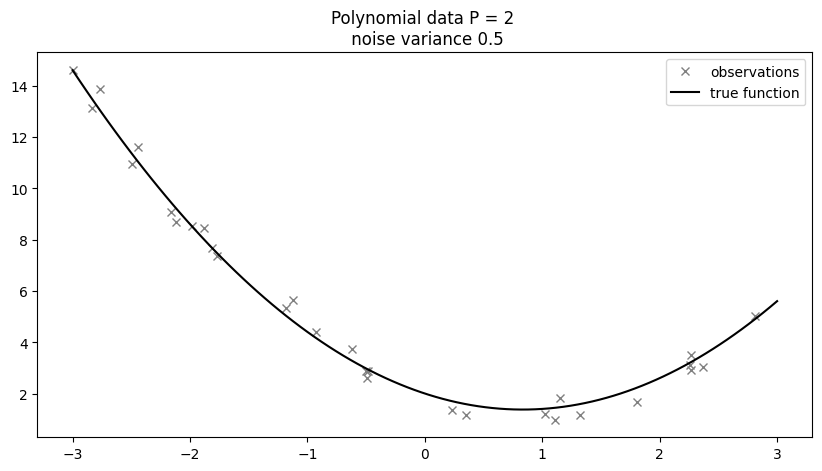

In [7]:
## data simulation generation
xmin = -3
xmax = 3
N_points = 30
noise_var = 0.5

# plot function
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
fig, (ax1) = plt.subplots(1,1, figsize = (10,5))


ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations')
ax1.plot(x_grid, y_grid_poly, color = 'k', label = 'true function')
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()

### Fitting some functions

##### task:
Let's fit some polynomials to these data, of different orders, starting from order 1, which is a line. To do so, use the `fit_norm2_least_square` function you created, in a for loop, that iterates over polynomials of different orders. Try, for example, order 1, 2, 8, and 20. Remember to fix the y limit  of your matplotlib graph to a given value; otherwise, you will see the function on a very big scale. To do so, use the `ax.set_ylim()` method from matplotlib axes.


In [8]:
if assesment_draw_and_fill:
    code = """
```python
## Dataset specs generation
xmin = ...
xmax = ...
N_points = ...
noise_var = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

# polynomial data
X_train_poly, t_train_poly = ...

## plot data and true model
fig, ax1 = plt.subplots(1,1, figsize = (10,5))

ax1.plot(..., ... , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
ax1.plot(..., ..., color = 'k', label = 'true function', linewidth = 3)
ax1.set_title(f'Polynomial data P = {...} \n noise variance {...}')
ax1.legend()

for i,poly_order in enumerate(...):
    
    ## generate polynomial features
    X_feat_poly = ...
    X_feat_grid = ...
    
    # fit model to polynomial data
    w_opt_poly = ...  
    
    # draw function on fitted model
    y_grid_poly = ...
    
    
    ## plotting
    ax1.plot(..., ... , linestyle = '-.' ,color = f'C{...}', label = f'order {...}')
    ax1.set_ylim([-1,15])
    ax1.legend(loc = 'upper right')
```
    """

    display(Markdown(code))


```python
## Dataset specs generation
xmin = ...
xmax = ...
N_points = ...
noise_var = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

# polynomial data
X_train_poly, t_train_poly = ...

## plot data and true model
fig, ax1 = plt.subplots(1,1, figsize = (10,5))

ax1.plot(..., ... , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
ax1.plot(..., ..., color = 'k', label = 'true function', linewidth = 3)
ax1.set_title(f'Polynomial data P = {...} 
 noise variance {...}')
ax1.legend()

for i,poly_order in enumerate(...):
    
    ## generate polynomial features
    X_feat_poly = ...
    X_feat_grid = ...
    
    # fit model to polynomial data
    w_opt_poly = ...  
    
    # draw function on fitted model
    y_grid_poly = ...
    
    
    ## plotting
    ax1.plot(..., ... , linestyle = '-.' ,color = f'C{...}', label = f'order {...}')
    ax1.set_ylim([-1,15])
    ax1.legend(loc = 'upper right')
```
    

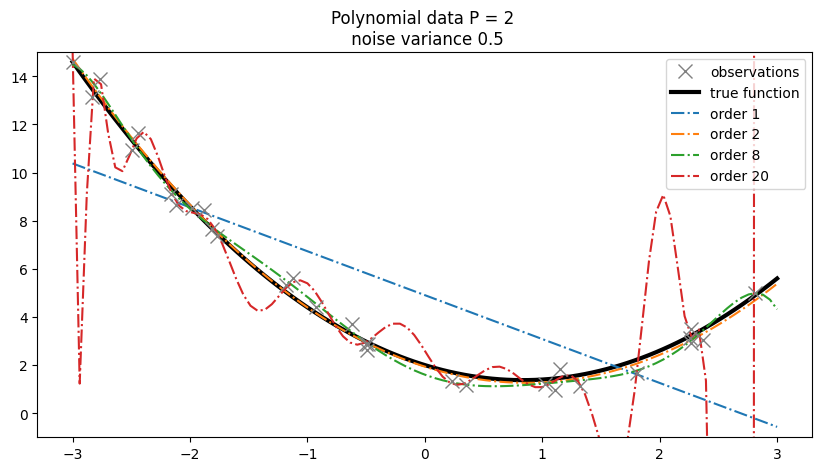

In [9]:
## Dataset specs generation
xmin = -3
xmax = 3
N_points = 30
noise_var = 0.5

# polinomial data
poly_degree = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

# polynomial data
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

## plot data and true model
fig, ax1 = plt.subplots(1,1, figsize = (10,5))

ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', linewidth = 3)
ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax1.legend()

for i,poly_order in enumerate([1,2,8,20]):
    
    ## generate polynomial features
    X_feat_poly = generate_features(X_train_poly, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)
    
    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )    
    
    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )
    
    
    ## plotting
    ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
    ax1.set_ylim([-1,15])
    ax1.legend(loc = 'upper right')

### Aleatoric uncertainty
##### task. 

Vary the noise variance and see what happens. Try for example $0.5$, $2$ and $5$. Add a for loop that iterates over different noise variances. For each noise variance you can create a subplot.

In [10]:
if assesment_draw_and_fill:
    code = """
```python
## Dataset specs generation
xmin = ...
xmax = ...
N_points = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

for noise_var in ...:

    # polynomial data
    X_train_poly, t_train_poly = ...
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (10,5))
    
    ax1.plot(..., ... , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(..., ..., color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {...} \\n noise variance {...}')
    ax1.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...
        
        # fit model to polynomial data
        w_opt_poly = ... 
        
        # draw function on fitted model
        y_grid_poly = ...
        
        
        ## plotting
        ax1.plot(..., ... , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
```
"""
    display(Markdown(code))


```python
## Dataset specs generation
xmin = ...
xmax = ...
N_points = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

for noise_var in ...:

    # polynomial data
    X_train_poly, t_train_poly = ...
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (10,5))
    
    ax1.plot(..., ... , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(..., ..., color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {...} \n noise variance {...}')
    ax1.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...
        
        # fit model to polynomial data
        w_opt_poly = ... 
        
        # draw function on fitted model
        y_grid_poly = ...
        
        
        ## plotting
        ax1.plot(..., ... , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
```


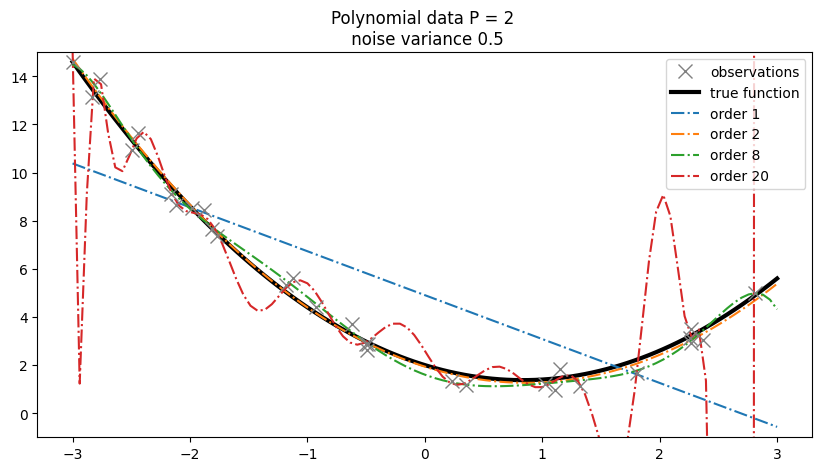

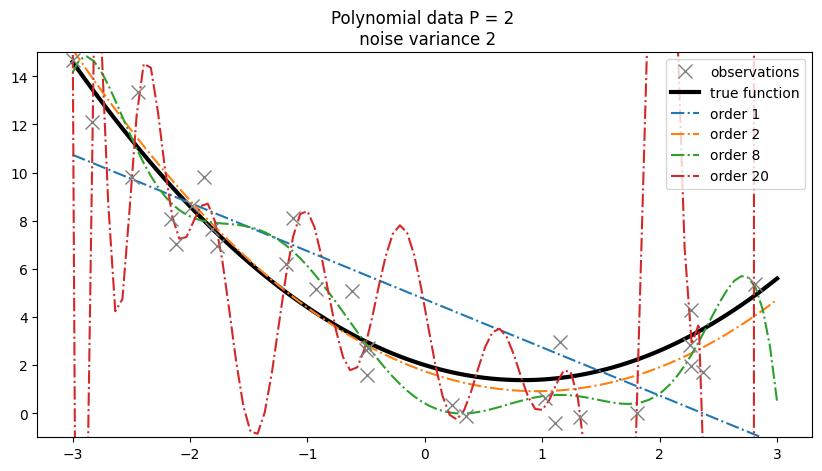

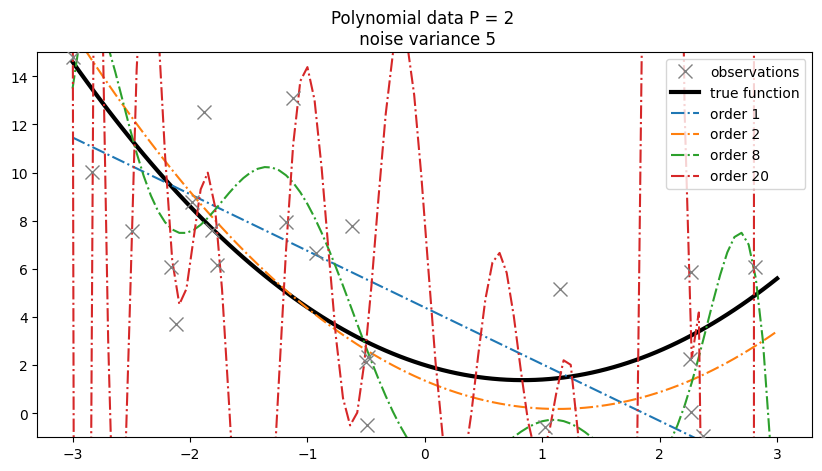

In [11]:
## Dataset specs generation
xmin = -3
xmax = 3
N_points = 30

# polinomial data
poly_degree = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

for noise_var in [0.5, 2, 5]:

    # polynomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (10,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
    ax1.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )    
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
    

##### Task: 

Now increase the number of training points from $30$ to $200$. Do you see the problem is solved?

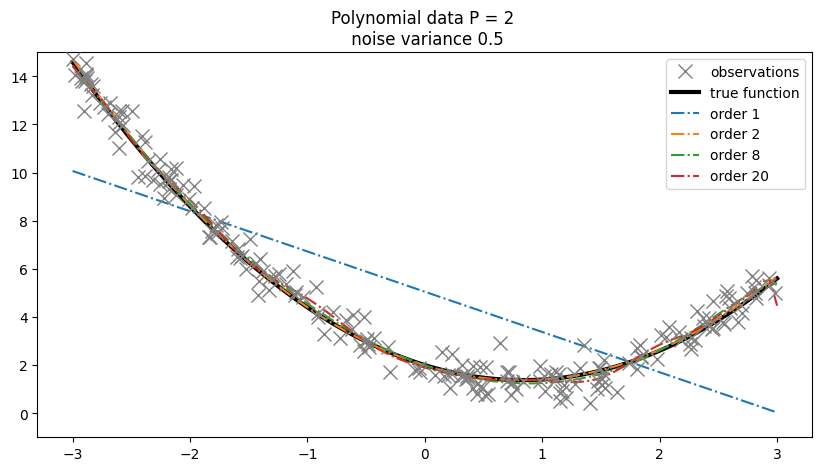

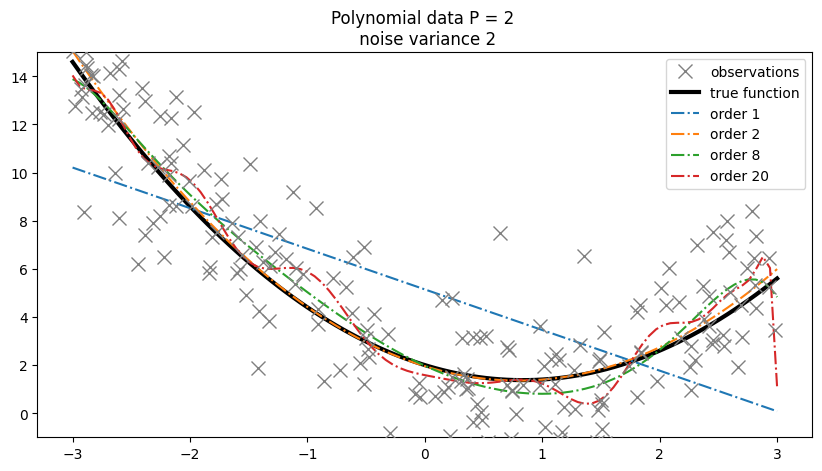

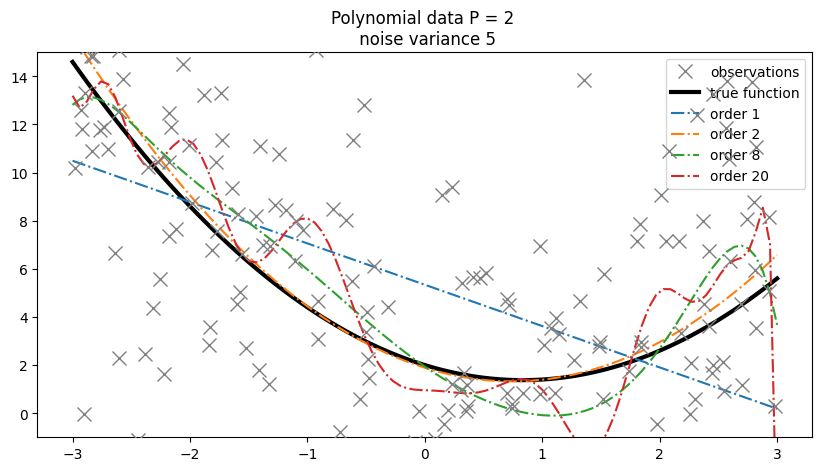

In [12]:
## Dataset specs generation
xmin = -3
xmax = 3
N_points = 200

# polinomial data
poly_degree = 2

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

for noise_var in  [0.5, 2, 5]:

    # polynomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (10,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'gray', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
    ax1.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )    
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'upper right')
    

### Epistemic uncertainty

We now want to show that, the lack of knowledge provided by the data itself can be reduced when more data is collected. To do so, we now use a noise variance of $0.0$ to generate the data.

##### Task: 

Use the same data generation process as before but with noise variance of $0.0$. In a for loop you should generate $3$ different number of training points: $3$, $10$, $100$. On each loop iteration create a plot where you fit polynomials of order $1$,$2$,$8$,$20$, drawing the corresponding functions. This can be done through a nested loop.

In [13]:
if assesment_draw_and_fill:
    code = """
```python
## Dataset specs generation
xmin = ...
xmax = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

for N_points in  ...:

    noise_var = 0.0
    
    # polinomial data
    X_train_poly, t_train_poly = ...
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (5,5))
    
    ax1.plot(..., ... , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(..., ..., color = 'gray', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \\n $N$ points {N_points}')
    ax1.legend()
    
    for i,poly_order in enumerate(...):
        
        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...
        
        # fit model to polynomial data
        w_opt_poly = ...
        
        # draw function on fitted model
        y_grid_poly = ...
        
        ## plotting
        ax1.plot(..., ... , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'lower left')
```
    """

    display(Markdown(code))


```python
## Dataset specs generation
xmin = ...
xmax = ...

# polinomial data
poly_degree = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

for N_points in  ...:

    noise_var = 0.0
    
    # polinomial data
    X_train_poly, t_train_poly = ...
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (5,5))
    
    ax1.plot(..., ... , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(..., ..., color = 'gray', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $N$ points {N_points}')
    ax1.legend()
    
    for i,poly_order in enumerate(...):
        
        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...
        
        # fit model to polynomial data
        w_opt_poly = ...
        
        # draw function on fitted model
        y_grid_poly = ...
        
        ## plotting
        ax1.plot(..., ... , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'lower left')
```
    

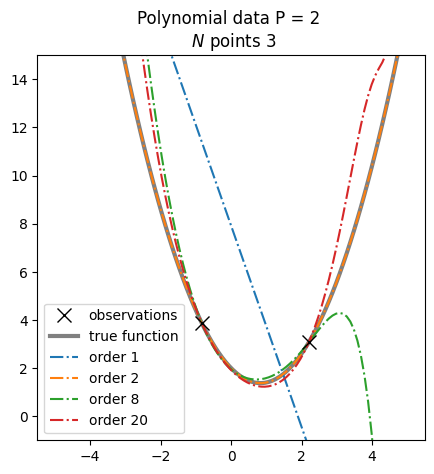

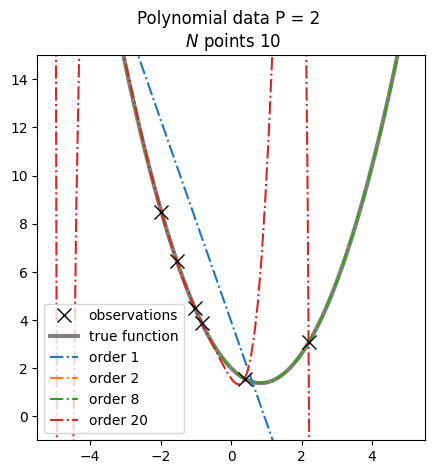

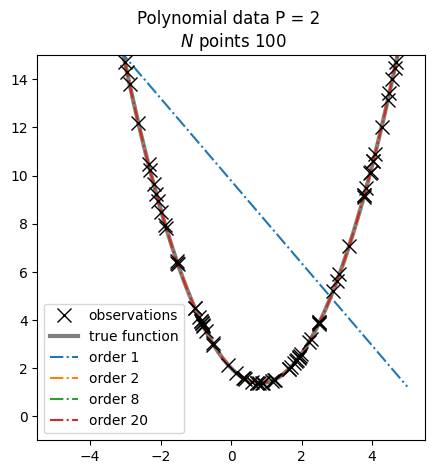

In [14]:
## Dataset specs generation
xmin = -3
xmax = 3

# polinomial data
poly_degree = 2

# plot function
xmin = -5
xmax = 5
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )


for N_points in  [3, 10, 100]:

    noise_var = 0.0
    
    # polinomial data
    X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
    
    ## plot data and true model
    fig, ax1 = plt.subplots(1,1, figsize = (5,5))
    
    ax1.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 10)
    ax1.plot(x_grid, y_grid_poly_true, color = 'gray', label = 'true function', linewidth = 3)
    ax1.set_title(f'Polynomial data P = {poly_degree} \n $N$ points {N_points}')
    ax1.legend()
    
    for i,poly_order in enumerate([1,2,8,20]):
        
        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)
        
        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly )
        
        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )
        
        ## plotting
        ax1.plot(x_grid, y_grid_poly , linestyle = '-.' ,color = f'C{i}', label = f'order {poly_order}')
        ax1.set_ylim([-1,15])
        ax1.legend(loc = 'lower left')
    

### Overfitting and underfitting

Overfitting and underfitting are generalization issues. When we lack enough expressiveness in our model to recover the true function, then we underfit the data. When we have more expressiveness, we explain part of the aleatoric uncertainty as model uncertainty and thus overexplain the data.

Since data is usually high dimensional, overfitting and underfitting are diagnosed by measuring performance measures over a test set because plotting the functions is not possible. This is a set of data different from the training data.

Let's mimic this behaviour.

##### Task

Using our functions, create a training dataset of $10$ points. Using the same generative procedure, create $30$ test points, and plot them. Use a noise variance of $2$ in the generative procedure. Use a seed of $5$ for the test set generation.

In [15]:
if assesment_draw_and_fill:
    code = """
```python
## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...
N_test = ...

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = ...
X_test_poly, t_test_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

## plot data and true model
fig, (ax) = plt.subplots(1,1, figsize = (15,7.5))

ax.plot(..., ... , 'x', color = 'k', label = 'train data', markersize = 10, zorder = 200)
ax.plot(..., ... , 'o', color = 'red', label = 'test data', markersize = 10, zorder = 200)
ax.plot(..., ..., color = 'k', label = 'true function', linewidth = 2)
ax.set_title(f'Polynomial data P = {poly_degree} \\n noise variance {noise_var}')
ax.legend()
```
"""
    display(Markdown(code))


```python
## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...
N_test = ...

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = ...
X_test_poly, t_test_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
x_grid_poly_features = ... # create associated features for the grid
y_grid_poly_true = ... # w*x + b

## plot data and true model
fig, (ax) = plt.subplots(1,1, figsize = (15,7.5))

ax.plot(..., ... , 'x', color = 'k', label = 'train data', markersize = 10, zorder = 200)
ax.plot(..., ... , 'o', color = 'red', label = 'test data', markersize = 10, zorder = 200)
ax.plot(..., ..., color = 'k', label = 'true function', linewidth = 2)
ax.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax.legend()
```


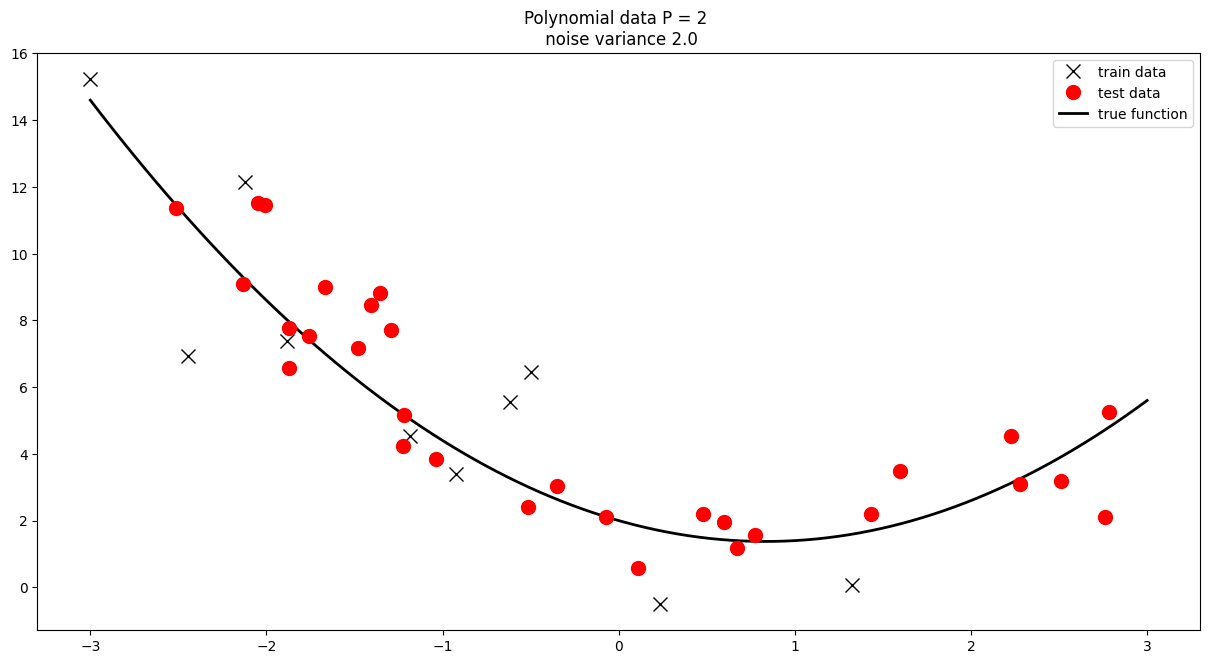

In [16]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 10
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

## plot data and true model
fig, (ax) = plt.subplots(1,1, figsize = (15,7.5))

ax.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'train data', markersize = 10, zorder = 200)
ax.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'test data', markersize = 10, zorder = 200)
ax.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax.legend()

##### Task

Now modify the above code to fit polynomials of order $2$ and $15$ on the training data, and plot them. This is a very similar for loop as the one you have been done previously. **Important** the test set must not be used to fit the model. 

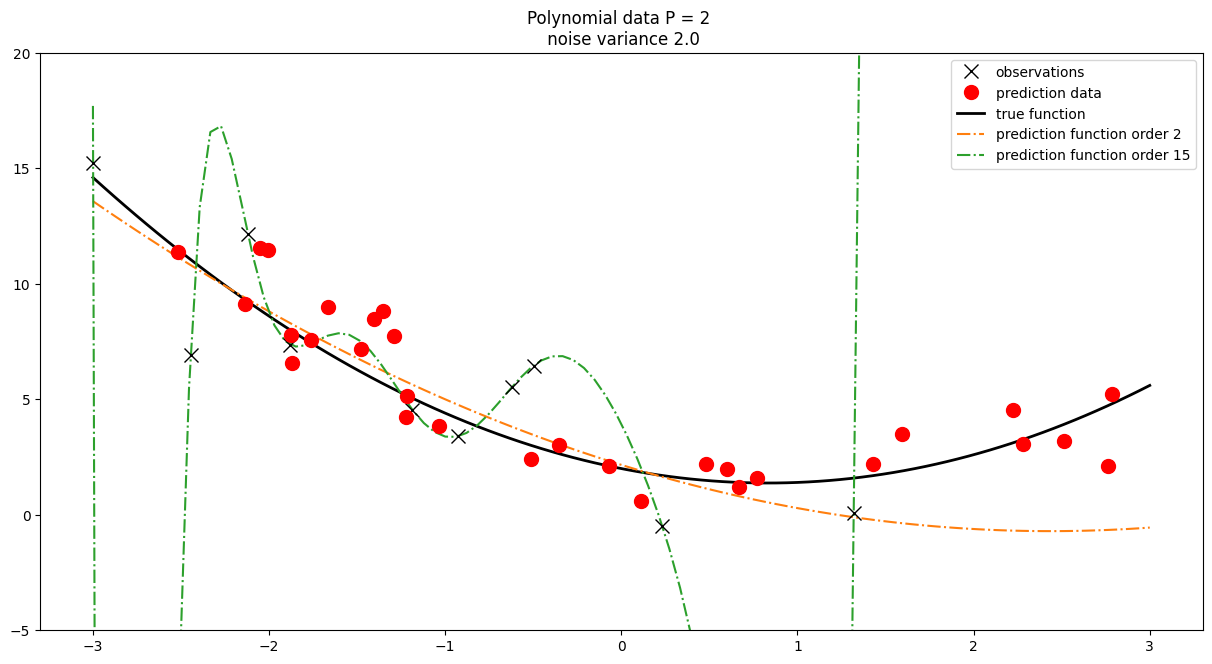

In [17]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 10
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

## plot data and true model
fig, ax = plt.subplots(1,1, figsize = (15,7.5))

ax.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax.legend()


for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )


    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )

    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )

    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    

    ## plotting
    ax.plot(x_grid, y_grid_poly, '-.' , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax.set_ylim([-5,20])
    ax.legend()

##### Task

Finally, over this last code compute the performance metric on both the train and test set, and print them through the console or in the plot. What do you observe?.

Use the sum of squared error as the performance metric.

Polynomial of order 2
Loss on training set 46.363
Loss on test set 163.144
Polynomial of order 15
Loss on training set 0.000
Loss on test set 2979458345.326


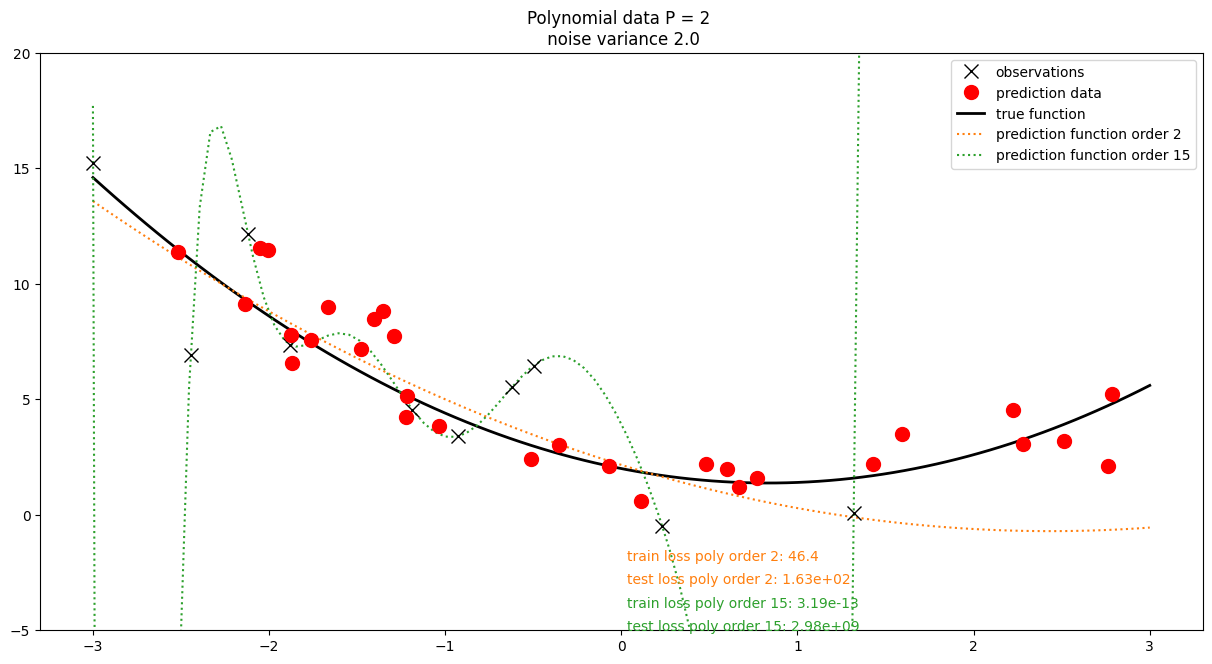

In [18]:
## Dataset generation
xmin = -3
xmax = 3
noise_var = 2.0
N_points = 10
N_test = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)
X_test_poly, t_test_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_test, seed = 5)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

## plot data and true model
fig, ax = plt.subplots(1,1, figsize = (15,7.5))

ax.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10, zorder = 200)
ax.plot(X_test_poly, t_test_poly , 'o', color = 'red', label = 'prediction data', markersize = 10, zorder = 200)
ax.plot(x_grid, y_grid_poly, color = 'k', label = 'true function', linewidth = 2)
ax.set_title(f'Polynomial data P = {poly_degree} \n noise variance {noise_var}')
ax.legend()

for i,poly_order in enumerate([2,15]):

    ## generate polynomial features
    X_feat_train_poly = generate_features(X_train_poly, poly_order)
    X_feat_test_poly = generate_features(X_test_poly, poly_order)
    X_feat_grid = generate_features(x_grid, poly_order)

    # fit model to polynomial data
    w_opt_poly = fit_norm2_least_square( X_feat_train_poly , t_train_poly )



    # draw function on fitted model
    y_grid_poly = computation_graph_linear(  
                                           X_feat_grid, 
                                           w_opt_poly ,
                                           b = 0 ,
                                        )
    
    ## predictions on train and test set
    y_pred_train_poly = computation_graph_linear(  
                                                   X_feat_train_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )
    
    y_pred_test_poly = computation_graph_linear(  
                                                   X_feat_test_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )

    ## compute loss on the train and test sets
    loss_train_poly = np.sum(squared_loss_function( y_pred_train_poly, t_train_poly ))
    loss_test_poly = np.sum(squared_loss_function( y_pred_test_poly, t_test_poly ))

    ## plotting
    ax.plot(x_grid, y_grid_poly, ':' , color = f'C{i+1}', label = f'prediction function order {poly_order}')
    ax.text(x_grid[-50],-2 -2*i, f'train loss poly order {poly_order}: {loss_train_poly:.3}', color = f'C{i+1}')
    ax.text(x_grid[-50],-2 -2*(i+1)+1, f'test loss poly order {poly_order}: {loss_test_poly:.3}', color = f'C{i+1}')
    ax.set_ylim([-5,20])
    ax.legend()

    print("=================================")
    print("=================================")
    print(f"Polynomial of order {poly_order}")
    print(f"Loss on training set {loss_train_poly:.3f}")
    print(f"Loss on test set {loss_test_poly:.3f}")

## Regularization

The concept of regularization refers to how can we modify the learning process in a way that generalization is improved, ie, that we encourage the model not to learning the data but the underlying generative process.

There are many ways in which a model can be regularized: from the data view point (data augmentation for example), modifying the model by changing its inductive bias or reducing/augmenting its expresivness, or by changing the underlying loss function either by setting a different observation model or placing regularizers on the parameters through a prior distribution. This is the case we will see.

The idea is to restrict the model parameters to lie within a ball of whatever radius. This ball is defined through a norm and we will consider the $L_2$ and $L_1$ norm. 

##### Task:

Using the same code structure you have been using before for train/test performance, epistemic uncertainty etc now perform the following steps.

Create a dataset of $30$ points with noise variance of $1$ (there is no train/test data now). Now fit polynomials of order $2$,$8$,$20$ with $L_2$ regularization with lambda being $0$ (no regularization) and $10$.

For each $\lambda$ and polynomial, print the resulting model. What do you observe?

In [19]:
if assesment_draw_and_fill:
    code = """```python
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...

# polinomial data
poly_degree = ...
X_train_poly, t_train_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
y_grid_poly_true = ...

for lam in ...:

    ## plot data and true model
    fig, ax = plt.subplots(1,1, figsize = (10,5))

    ax.plot(..., ... , 'x', color = 'k', label = 'observations', markersize = 10)
    ax.plot(..., ..., color = 'gray', label = 'true function')
    ax.set_title(f'Polynomial data P = {poly_degree} \\n $\lambda$ {lam}')
    ax.legend()

    for i,poly_order in enumerate(...):

        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...

        # fit model to polynomial data
        w_opt_poly = ...


        # draw function on fitted model
        y_grid_poly = ...

        ## plotting
        ax.plot(..., ...,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax.set_ylim([-1,16])
        ax.legend()

        
        print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")
    print("----------------------------")
```"""
    display(Markdown(code))

```python
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...

# polinomial data
poly_degree = ...
X_train_poly, t_train_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
y_grid_poly_true = ...

for lam in ...:

    ## plot data and true model
    fig, ax = plt.subplots(1,1, figsize = (10,5))

    ax.plot(..., ... , 'x', color = 'k', label = 'observations', markersize = 10)
    ax.plot(..., ..., color = 'gray', label = 'true function')
    ax.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax.legend()

    for i,poly_order in enumerate(...):

        ## generate polynomial features
        X_feat_poly = ...
        X_feat_grid = ...

        # fit model to polynomial data
        w_opt_poly = ...


        # draw function on fitted model
        y_grid_poly = ...

        ## plotting
        ax.plot(..., ...,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax.set_ylim([-1,16])
        ax.legend()

        
        print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")
    print("----------------------------")
```

/tmp/ipykernel_2213786/1410377734.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")


Lambda 0.0 poly order 2 weights ['1.8708', '-1.6167', '0.9045']
Lambda 0.0 poly order 8 weights ['1.2035', '-2.1437', '2.8672', '-0.0069', '-1.1082', '0.0533', '0.2058', '-0.0055', '-0.0120']
Lambda 0.0 poly order 20 weights ['3.1907', '-14.2636', '-6.0223', '106.0932', '18.2349', '-287.5100', '-29.5620', '362.3016', '37.6032', '-247.7282', '-31.5988', '98.8136', '15.4271', '-23.5894', '-4.3201', '3.3124', '0.6851', '-0.2518', '-0.0572', '0.0080', '0.0019']
----------------------------
Lambda 10 poly order 2 weights ['1.0826', '-1.4674', '1.0469']
Lambda 10 poly order 8 weights ['1.1081', '-0.7870', '0.6931', '-0.4471', '0.2304', '0.0710', '-0.0439', '-0.0032', '0.0025']
Lambda 10 poly order 20 weights ['0.9972', '-0.6515', '0.5967', '-0.4353', '0.4247', '-0.3097', '0.2398', '-0.1307', '-0.0011', '0.0960', '-0.1317', '0.1472', '0.0805', '-0.1167', '-0.0317', '0.0318', '0.0077', '-0.0038', '-0.0009', '0.0002', '0.0000']
----------------------------


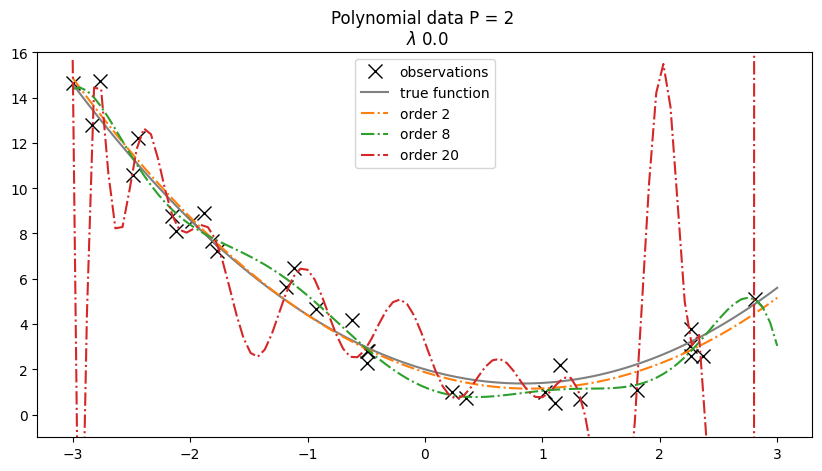

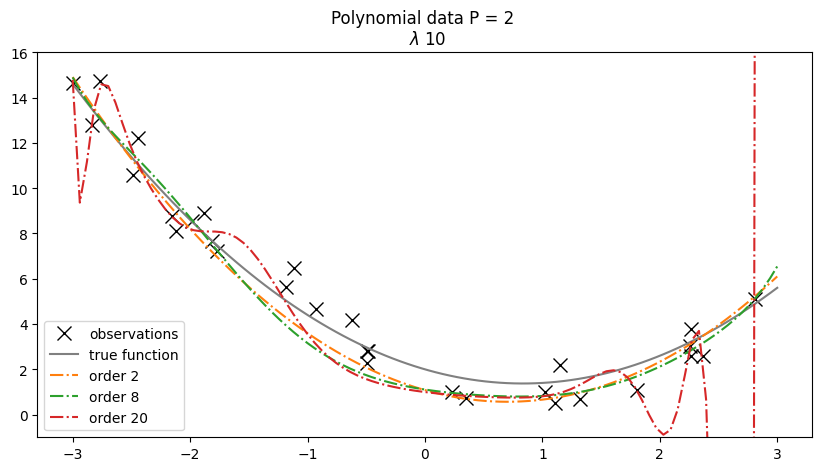

In [20]:
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = -3
xmax = 3
noise_var = 1
N_points = 30

# polinomial data
poly_degree = 2
X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )

for lam in [0.0,10]:

    ## plot data and true model
    fig, ax = plt.subplots(1,1, figsize = (10,5))

    ax.plot(X_train_poly, t_train_poly , 'x', color = 'k', label = 'observations', markersize = 10)
    ax.plot(x_grid, y_grid_poly_true, color = 'gray', label = 'true function')
    ax.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax.legend()

    for i,poly_order in enumerate([2,8,20]):

        ## generate polynomial features
        X_feat_poly = generate_features(X_train_poly, poly_order)
        X_feat_grid = generate_features(x_grid, poly_order)

        # fit model to polynomial data
        w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly, lam = lam )


        # draw function on fitted model
        y_grid_poly = computation_graph_linear(  
                                               X_feat_grid, 
                                               w_opt_poly ,
                                               b = 0 ,
                                            )

        ## plotting
        ax.plot(x_grid, y_grid_poly,'-.' , color = f'C{i+1}', label = f'order {poly_order}')
        ax.set_ylim([-1,16])
        ax.legend()

        
        print(f"Lambda {lam} poly order {poly_order} weights {[f'{float(w):.4f}' for w in w_opt_poly]}")
    print("----------------------------")

### Feature normalization

While normalization deserves its own chapter in the context of parameter regularization and optimization convergence, it can help understand why it is also important for a good convergence and learning of the model. Normalization is the process of getting some features and put them within the same scale. Overall, it helps the learning process, and also make the model let's prone to overfitting. Polynomial regression is an easy example of why.

Consider the linear combination implemented by a linear model:

\begin{split}
    y = w_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4
\end{split}

what would happen if the scale of $x_4$ is much bigger than that of $x_1$?. This would imply that the linear combination is dominated by $x_4$ feature. If the relative importance is not so high, learning to adapt the rest of the weights will take time. Moreover over the gradient scale will have a different impact on the learning process, and so vanilla gradient descent will fail to successfully train "fast". Moreover, if for whatever reason a high value of this feature encourages the model to learn some part of the data better, then the model can get stuck on making this contribution bigger, ending up in overfitting. This is, in fact, what happens in polynomial regression, since here we have:


\begin{split}
    y = w_0 + w_1x + w_2x^2 + w_3x^3 + w_4x^4
\end{split}

Since $x^4$ is much bigger than $x$, then its contribution is bigger. This implies that at the beginning of the learning process, the model is prone to model high-order features, which are wavy and can learn to fit the data easily. Even a regularized model that makes the weights go to zero, will get stuck. Why? because even a small value for $w_4$ can be manifested as a huge contribution to $y$ due to $x^4$ being bigger than, for example $x$; so even if the regularizer makes $w_4$ go to $0$ the effect will not disappear, because this reduction in magnitude will be compensated by $x^4$. At the same time the rest of coefficients will be made small by the regularizer, and the overall contribution will be given by  $x^4$. To avoid this, we can just normalize the data by subtracting the mean and dividing by the standard deviation. Let's compare the behaviour of regularized and non-regularized models, comparing data and non-data normalization.

In machine learning there are two options. For evaluation we can just normalize data and perform all computations on normalized space. For predictions, we usually normalize data, perform prediction, and unormalized the output. Since normalization is a linear operator, it will not change the shape of the function learnt. 

Moreover, it can be shown that without regularization, feature normalization is not relevant when optimizing a linear model through exact minimization via least squares with a $L_2$ norm. **Exercise**

Let's visualize the effect of training over normalized features. In this case we will be normalizing both targets $\t$ and features $\x$.

##### Task: 

Modify code in previous step to add a for loop that iterates over the option of normalizing and not normalizing the data. Show, within the same graph, a polynomial fitted with and without data normalization. Try polinomials of order: $4,8,10,20$. The first column of the matrix $\X$ (which should be a vector of $1$s) must be removed from the normalization. To perform all this do the following sub tasks.

##### Sub Task 1:
Implement a function that normalizes data to zero mean and 1 stdev. The function must have this signature:

```python
def norm_data(X, mean = None, std = None ):
    ...
    return  X_norm, mean, std
```

When the mean is None, the function computes the mean and std, and return mean, std and normalized data. When the function is called with arguments for mean and std, the function uses these values to normalize the data. With this we can use the function for normalization and mean and std computation, and use the same function to normalize data with a given mean and value. Why? Because test data or prediction data must be normalized with statistics computed with the training set, because is what we have available when training our models.


In [21]:
if assesment_draw_and_fill:
    code = """
```python
def norm_data(X, mean = None, std = None ):
    if mean is None:
        mean = ...
        std  = ...

    norm_data = ...
    return  ..., ..., ...
```
"""
    display(Markdown(code))


```python
def norm_data(X, mean = None, std = None ):
    if mean is None:
        mean = ...
        std  = ...

    norm_data = ...
    return  ..., ..., ...
```


Execute the following code to test your function implementation before going to the next task. Note that in this function, $\X$ is the design matrix and we must normalize each column, which is each feature.

```python
X = np.linspace(-10,10,50).reshape(10,5)
Y = np.arange(50).reshape(10,5)
    
X_norm, mean, std = norm_data(X)
Y_norm,_,_, = norm_data(Y, mean, std)

print('X ', X)
print('X norm ',X_norm)
print('mean ', mean)
print('std ', std)
print('Y norm ', Y_norm)
```

In [22]:
X = np.linspace(-10,10,50).reshape(10,5)
Y = np.arange(50).reshape(10,5)
    
X_norm, mean, std = norm_data(X)
Y_norm,_,_, = norm_data(Y, mean, std)

print('X ', X)
print('X norm ',X_norm)
print('mean ', mean)
print('std ', std)
print('Y norm ', Y_norm)

X  [[-10.          -9.59183673  -9.18367347  -8.7755102   -8.36734694]
 [ -7.95918367  -7.55102041  -7.14285714  -6.73469388  -6.32653061]
 [ -5.91836735  -5.51020408  -5.10204082  -4.69387755  -4.28571429]
 [ -3.87755102  -3.46938776  -3.06122449  -2.65306122  -2.24489796]
 [ -1.83673469  -1.42857143  -1.02040816  -0.6122449   -0.20408163]
 [  0.20408163   0.6122449    1.02040816   1.42857143   1.83673469]
 [  2.24489796   2.65306122   3.06122449   3.46938776   3.87755102]
 [  4.28571429   4.69387755   5.10204082   5.51020408   5.91836735]
 [  6.32653061   6.73469388   7.14285714   7.55102041   7.95918367]
 [  8.36734694   8.7755102    9.18367347   9.59183673  10.        ]]
X norm  [[-1.5666989  -1.5666989  -1.5666989  -1.5666989  -1.5666989 ]
 [-1.21854359 -1.21854359 -1.21854359 -1.21854359 -1.21854359]
 [-0.87038828 -0.87038828 -0.87038828 -0.87038828 -0.87038828]
 [-0.52223297 -0.52223297 -0.52223297 -0.52223297 -0.52223297]
 [-0.17407766 -0.17407766 -0.17407766 -0.17407766 -0.174

##### Sub Task 2:

Implement the loop using this function. Be aware of removing and readding the first column after normalization so that the first column remains a column of $1$s.

When taking predictions on your prediction grid, to plot the function, the predictions $y$ must be un normalized using the reverse process to normalization:

\begin{split}
y_\text{un normalized} = y_{\text{normalized}} \cdot \text{stdev} + \text{mean}
\end{split}

where $\text{stdev}, \text{mean}$ must be those obtained with the training set.

In [23]:
if assesment_draw_and_fill:
    code = """
```python
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...

# polinomial data
poly_degree = ...
_X_train_poly, _t_train_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
y_grid_poly_true = ...

for lam in [...,...]:
    
    ## plot data and true model
    fig, (ax) = plt.subplots(1,1, figsize = (10,5))

    ax.plot(..., ... , 'x', color = 'k', label = 'observations', zorder = 10)
    ax.plot(..., ..., color = 'k', label = 'true function', zorder = 5)
    ax.set_title(f'Polynomial data P = {poly_degree} \\n $\lambda$ {lam}')
    ax.legend()
    
    for norm in [False,True]: 

        for i,poly_order in enumerate([...]):
        
            # grab original unormalized data
            X_train_poly, t_train_poly = copy.deepcopy(_X_train_poly), copy.deepcopy(_t_train_poly)
 
            ## generate polynomial features
            X_feat_poly = ...
            X_feat_grid_poly = ...

            if norm:
                # we normalize all but first column, which is a columns of ones.
                X_feat_poly, X_mean_poly, X_std_poly = ...
                X_feat_grid_poly, _, _ = ...
             
                # concatenate back ones.
                X_feat_poly = np.hstack([np.ones((X_feat_poly.shape[0], 1)), X_feat_poly])
                X_feat_grid_poly = np.hstack([np.ones((X_feat_grid_poly.shape[0], 1)), X_feat_grid_poly])

                t_train_poly, t_mean_poly, t_std_poly = ...
                
            # fit model to polynomial data
            w_opt_poly = ...


            # draw function on fitted model
            y_grid_poly = ...

            # unormalize predictions
            if norm:
                y_grid_poly = ...
                
            linestyle = '-'
            if norm:
                linestyle = '--'

            ## plotting
            ax.plot(..., ... , color = f'C{i+1}', linestyle = linestyle, label = f'order {poly_order} normalize {norm}')
            ax.set_ylim([-1,16])
            ax.legend()
```
"""
    display(Markdown(code))


```python
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = ...
xmax = ...
noise_var = ...
N_points = ...

# polinomial data
poly_degree = ...
_X_train_poly, _t_train_poly = ...

# plot function
xmin = ...
xmax = ...
N_grid = ...
x_grid = ...

# true functions
y_grid_poly_true = ...

for lam in [...,...]:
    
    ## plot data and true model
    fig, (ax) = plt.subplots(1,1, figsize = (10,5))

    ax.plot(..., ... , 'x', color = 'k', label = 'observations', zorder = 10)
    ax.plot(..., ..., color = 'k', label = 'true function', zorder = 5)
    ax.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax.legend()
    
    for norm in [False,True]: 

        for i,poly_order in enumerate([...]):
        
            # grab original unormalized data
            X_train_poly, t_train_poly = copy.deepcopy(_X_train_poly), copy.deepcopy(_t_train_poly)
 
            ## generate polynomial features
            X_feat_poly = ...
            X_feat_grid_poly = ...

            if norm:
                # we normalize all but first column, which is a columns of ones.
                X_feat_poly, X_mean_poly, X_std_poly = ...
                X_feat_grid_poly, _, _ = ...
             
                # concatenate back ones.
                X_feat_poly = np.hstack([np.ones((X_feat_poly.shape[0], 1)), X_feat_poly])
                X_feat_grid_poly = np.hstack([np.ones((X_feat_grid_poly.shape[0], 1)), X_feat_grid_poly])

                t_train_poly, t_mean_poly, t_std_poly = ...
                
            # fit model to polynomial data
            w_opt_poly = ...


            # draw function on fitted model
            y_grid_poly = ...

            # unormalize predictions
            if norm:
                y_grid_poly = ...
                
            linestyle = '-'
            if norm:
                linestyle = '--'

            ## plotting
            ax.plot(..., ... , color = f'C{i+1}', linestyle = linestyle, label = f'order {poly_order} normalize {norm}')
            ax.set_ylim([-1,16])
            ax.legend()
```


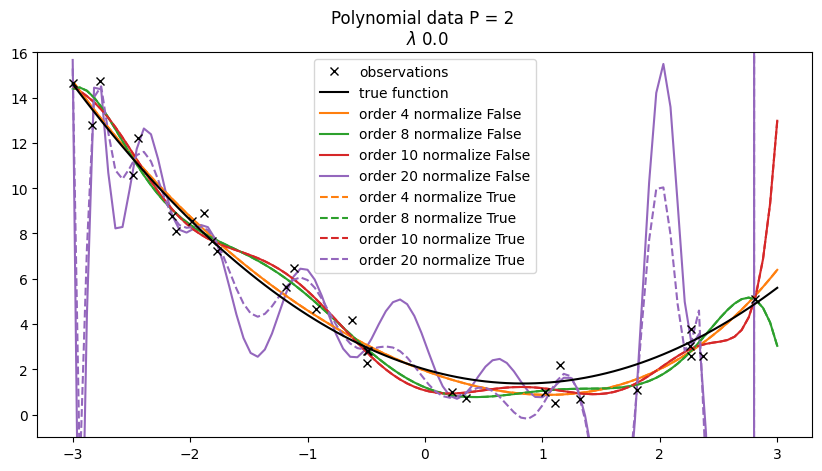

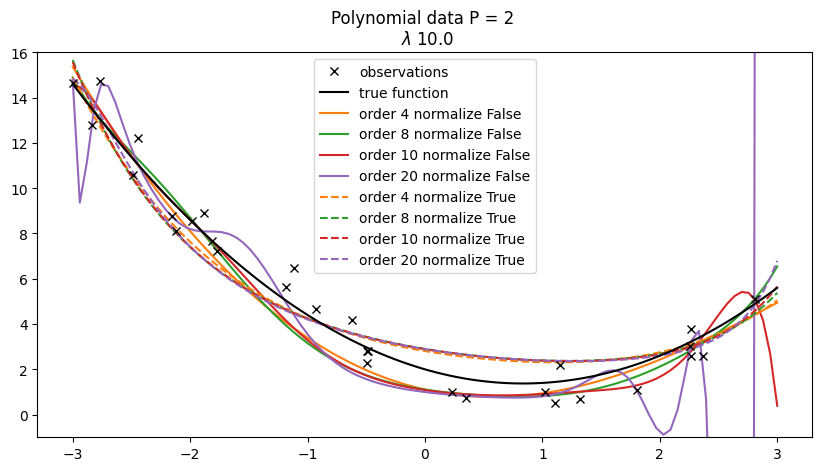

In [24]:
%matplotlib inline
plt.close("all")

## Dataset generation
xmin = -3
xmax = 3
noise_var = 1
N_points = 30

# polinomial data
poly_degree = 2
_X_train_poly, _t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree, noise_var, N_points, seed = 1)

# plot function
xmin = -3
xmax = 3
N_grid = 100
x_grid = np.linspace(xmin, xmax, N_grid)

# true functions
y_grid_poly_true = computation_graph_linear(  
                                           generate_features(x_grid, poly_degree) , 
                                           w = np.array([[2],[-1.5],[0.9]]) ,
                                           b = 0 ,
                                        )
for lam in [0.0,10.0]:
    
    ## plot data and true model
    fig, (ax) = plt.subplots(1,1, figsize = (10,5))

    ax.plot(_X_train_poly, _t_train_poly , 'x', color = 'k', label = 'observations', zorder = 10)
    ax.plot(x_grid, y_grid_poly_true, color = 'k', label = 'true function', zorder = 5)
    ax.set_title(f'Polynomial data P = {poly_degree} \n $\lambda$ {lam}')
    ax.legend()
    
    for norm in [False,True]: 

        for i,poly_order in enumerate([4,8,10,20]):
            # grab original unormalized data
            X_train_poly, t_train_poly = copy.deepcopy(_X_train_poly), copy.deepcopy(_t_train_poly)
 
            ## generate polynomial features
            X_feat_poly = generate_features(X_train_poly, poly_order)
            X_feat_grid_poly = generate_features(x_grid, poly_order)

            if norm:
                # we normalize all but first column, which is a columns of ones.
                X_feat_poly, X_mean_poly, X_std_poly = norm_data(X_feat_poly[:,1:])
                X_feat_grid_poly, _, _ = norm_data(X_feat_grid_poly[:,1:], mean = X_mean_poly, std = X_std_poly)
             
                # concatenate back ones.
                X_feat_poly = np.hstack([np.ones((X_feat_poly.shape[0], 1)), X_feat_poly])
                X_feat_grid_poly = np.hstack([np.ones((X_feat_grid_poly.shape[0], 1)), X_feat_grid_poly])

                t_train_poly, t_mean_poly, t_std_poly = norm_data(t_train_poly)
                
            # fit model to polynomial data
            w_opt_poly = fit_norm2_least_square( X_feat_poly , t_train_poly, lam = lam )


            # draw function on fitted model
            y_grid_poly = computation_graph_linear(  
                                                   X_feat_grid_poly, 
                                                   w_opt_poly ,
                                                   b = 0 ,
                                                )

            # unormalize predictions
            if norm:
                y_grid_poly = y_grid_poly * t_std_poly + t_mean_poly
                
            linestyle = '-'
            if norm:
                linestyle = '--'

            ## plotting
            ax.plot(x_grid, y_grid_poly , color = f'C{i+1}', linestyle = linestyle, label = f'order {poly_order} normalize {norm}')
            ax.set_ylim([-1,16])
            ax.legend()

**Question:** With $\lambda=0$ both normalized and unnormalized models should be the same. Why is this not the case in the polynomial of order 20?

#### Feature selection through $L_1$ regularization

Linear regresion with $L_1$ regularization is also knowns as Lasso. Since $L_1$ norm is non-differentiable at $x=0$, state of the art optimization of this model is based on coordinate descent. Gradient descent could be used using the concept of subgradient. In fact software as pytorch just define the derivative at $x=0$ to be zero, which is one of the possible values for the subgradient. Neverthless this is slower than using coordinate descent.

$L_1$ regularization is able to select features from within the data, this means, setting the coefficients to zero. For example if:

\begin{split}
y = b + w_1 \cdot x + w_2 \cdot x^2  + w_3 \cdot x^3
\end{split}

but our data is linear, then $L_1$ regularization can set the coefficients $w_2,w_3$ to zero. This is also known as shrinkage. 

Any loss function can be regularized through $L_1$ regularizaiton, since this is just a penalty we put on the parameters. For our polynomial regression model with squared loss we have:

\begin{split}
    L(t,x,w) = \sum^N_{n=1} (t_n - \sum^K_{k=1} (x_n^T)^k\cdot w_k)^2 + \sum^K_{k=1} \lambda_k || w_k ||_1
\end{split}

where $\lambda$ denotes the strength of the regularizer, i.e how much do we take it into account. We use same $\lambda$ for any parameter.

##### The effect of normalization

Here the effect of not normalizing the data is very visible. When the data is not normalized, since any coefficient is equally pushed to zero, the model tends to push to zero low-order polynomial coefficients than high order, even when the data generating process is from a low order polynomial.

To see so assume we draw data from a two order polynomial and fit a $5$ order polynomial with $L_1$ regularization, with and without normalization, using the sklearn library.

Note that normalizing the targets changes the scale of the problem and the $\lambda$ value needs to be decreased in this cases as well. To illustrate the effect of normalization with $L_1$ regularization I will not normalize the targets.

Since $L_1$ regularization is optimized throught coordinate descent, we will use the implementation in sklearn as a proxy to introduce this library. Sklearn is basically a python library that implements many of the mechanisms used in machine learning. For example, beyond many algorithms, it includes functionality to normalize data, to create pipelines that apply several steps (for example normalize, fit model, evaluate model) and many more things.

A linear model with $L_1$ regularization is known in sklearn as Lasso. The corresponding model using $L_2$ is called Ridge. We can import the Lasso model from sklearn through:

```python
from sklearn.linear_model import Lasso
```

Now giving a design matrix $\X$ and corresponding targets $\t$ we can fit the model through:

```python
# model
model = Lasso(alpha=reg_coeff) # alpha is what is called lambda by us.

# optimize model
model.fit(X_train, t_train)
```

Predictions on new points are obtained by:

```python
y_grid = model.predict(X_grid)
```

As you can see everything is very easy. The fit method runs the optimization process, the predict method uses the resulting optimized $\w$ to perform dot product to take predictions.

The resulting coefficients can be accessed through:

```python
model.coef_ # rest of parameters
model.intercept_ # bias
```

More information in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

On the other side, sklearn also provides functionality to normalize data through the StandardScaler class, imported and used by:

```python
from sklearn.preprocessing import StandardScaler

# Normalize data 
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train) # scales the training data and also compute and keeps statistics internally
X_grid_scaled = scaler_X.transform(X_grid)  # use the precomputed statistics to normalize x_grid
```

##### Task

Using the same data generation process as always (polynomial data of order $2$, within $-3$ and $3$ limits) generate $10$ training points with noise variance of $0$. Use a similar loop as the one you use before to train normalized and unormalized features using $L_1$ regularization. Modify your previous code in the following ways:

* Normalization must be done with sklearn
* Use the lasso model
* Normalize only input $\X$.
* When generating the polynomial features, do not add the bias column of $1s$ (add_bias = False in your function) because the Lasso implementation does it internally.

Test regularization coefficients: $0.1, 0.5$.

Print the resulting coefficcients and intercept through the console.

In [25]:
if assesment_draw_and_fill:
    code = """
```python
%matplotlib inline
plt.close("all")

## Generate dataset
poly_degree_data = ...
noise_var = ...
N_data = ...
xmin = ...
xmax = ...

X_train_poly, t_train_poly = ...

# ===========
## Train model

# model specification
poly_degree_model = ...  # assume our data follows a polynomial of order 10
X_train_feat = ...

for reg_coeff in ...:

    print("================================")
    print("================================")
    print("================================")
    print(f"Regularization coefficient {reg_coeff}")

    ## Figure grid
    fig, ax_list  = plt.subplots(1,2,figsize = (10,5))
    
    for id_fig,norm_data in enumerate([True, False]):
        if norm_data:
            ## ================
            ## Normalized Model
        
            # Normalize data 
            scaler_X = ...
            
            X_train_feat_scaled = scaler_X.fit_transform(...)
            t_train_poly_scaled = t_train_poly 
        else:
            X_train_feat_scaled = X_train_feat
            t_train_poly_scaled = t_train_poly 
            
        # model
        lasso = Lasso(alpha=...)
        
        # optimize model
        lasso.fit(..., ...)
        
        # Print coefficient values
        print("=============")
        if norm_data:
            print("Normalized")
        else:
            print("Un normalized")
            
        print("Coeficientes óptimos:", lasso.coef_)
        print("Intercepto:", lasso.intercept_)
        
        # ===========
        ## Plot regressed model
        N_grid = 100
        x_grid = ...
        X_grid_feat = ...
        if norm_data:
            X_grid_feat_scaled = ...  # escalar mismo rango
        else:
            X_grid_feat_scaled = ...
        
        # Predecir con el model
        y_grid = lasso.predict(...)
        
        # Plot
        ax_list[id_fig].plot(..., ..., 'o', color='C0', label='Train data')
        if norm_data:
            ax_list[id_fig].plot(..., ..., color='C1', label='Normalized model')
        else:
            ax_list[id_fig].plot(..., ..., color='C1', label='Unormalized model')
        ax_list[id_fig].set_xlabel('X')
        ax_list[id_fig].set_ylabel('t')
        ax_list[id_fig].set_title(f'Lasso Polynomial Fit (degree={poly_degree_model}, alpha={reg_coeff})')
        ax_list[id_fig].legend()
```
"""

    display(Markdown(code))


```python
%matplotlib inline
plt.close("all")

## Generate dataset
poly_degree_data = ...
noise_var = ...
N_data = ...
xmin = ...
xmax = ...

X_train_poly, t_train_poly = ...

# ===========
## Train model

# model specification
poly_degree_model = ...  # assume our data follows a polynomial of order 10
X_train_feat = ...

for reg_coeff in ...:

    print("================================")
    print("================================")
    print("================================")
    print(f"Regularization coefficient {reg_coeff}")

    ## Figure grid
    fig, ax_list  = plt.subplots(1,2,figsize = (10,5))
    
    for id_fig,norm_data in enumerate([True, False]):
        if norm_data:
            ## ================
            ## Normalized Model
        
            # Normalize data 
            scaler_X = ...
            
            X_train_feat_scaled = scaler_X.fit_transform(...)
            t_train_poly_scaled = t_train_poly 
        else:
            X_train_feat_scaled = X_train_feat
            t_train_poly_scaled = t_train_poly 
            
        # model
        lasso = Lasso(alpha=...)
        
        # optimize model
        lasso.fit(..., ...)
        
        # Print coefficient values
        print("=============")
        if norm_data:
            print("Normalized")
        else:
            print("Un normalized")
            
        print("Coeficientes óptimos:", lasso.coef_)
        print("Intercepto:", lasso.intercept_)
        
        # ===========
        ## Plot regressed model
        N_grid = 100
        x_grid = ...
        X_grid_feat = ...
        if norm_data:
            X_grid_feat_scaled = ...  # escalar mismo rango
        else:
            X_grid_feat_scaled = ...
        
        # Predecir con el model
        y_grid = lasso.predict(...)
        
        # Plot
        ax_list[id_fig].plot(..., ..., 'o', color='C0', label='Train data')
        if norm_data:
            ax_list[id_fig].plot(..., ..., color='C1', label='Normalized model')
        else:
            ax_list[id_fig].plot(..., ..., color='C1', label='Unormalized model')
        ax_list[id_fig].set_xlabel('X')
        ax_list[id_fig].set_ylabel('t')
        ax_list[id_fig].set_title(f'Lasso Polynomial Fit (degree={poly_degree_model}, alpha={reg_coeff})')
        ax_list[id_fig].legend()
```


Regularization coefficient 0.1
Normalized
Coeficientes óptimos: [-1.79687577  2.45082594 -0.02227827  0.         -0.        ]
Intercepto: [6.16249905]
Un normalized
Coeficientes óptimos: [-0.68559186  0.46896388 -0.42719535  0.          0.02377135]
Intercepto: [2.55026095]
Regularization coefficient 0.5
Normalized
Coeficientes óptimos: [-1.55066856  2.1438306  -0.12755676  0.         -0.        ]
Intercepto: [6.16249905]
Un normalized
Coeficientes óptimos: [-0.          0.         -0.75440073  0.          0.03626701]
Intercepto: [3.19910377]


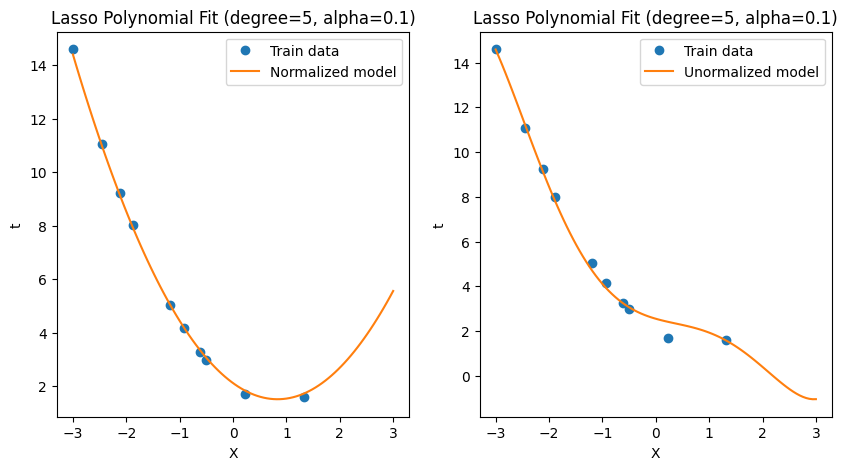

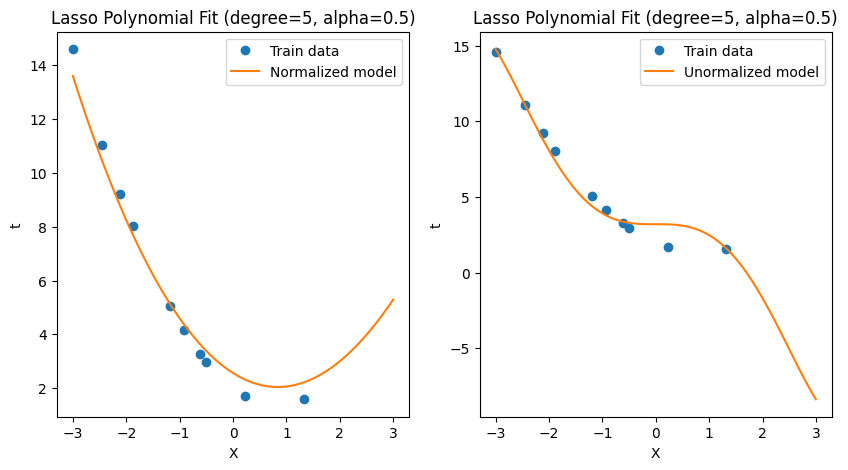

In [26]:
%matplotlib inline
plt.close("all")

## Generate dataset
poly_degree_data = 2
noise_var = 0.0
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

# ===========
## Train model

# model specification
poly_degree_model = 5  # assume our data follows a polynomial of order 10
X_train_feat = generate_features(X_train_poly, poly_degree=poly_degree_model, add_bias = False)

for reg_coeff in [0.1, 0.5]:

    print("================================")
    print("================================")
    print("================================")
    print(f"Regularization coefficient {reg_coeff}")

    ## Figure grid
    fig, ax_list  = plt.subplots(1,2,figsize = (10,5))
    
    for id_fig,norm_data in enumerate([True, False]):
        if norm_data:
            ## ================
            ## Normalized Model
        
            # Normalize data 
            scaler_X = StandardScaler()
            # scaler_T = StandardScaler()
            X_train_feat_scaled = scaler_X.fit_transform(X_train_feat)
            t_train_poly_scaled = t_train_poly #scaler_T.fit_transform(t_train_poly).ravel()
        else:
            X_train_feat_scaled = X_train_feat
            t_train_poly_scaled = t_train_poly 
            
        # model
        lasso = Lasso(alpha=reg_coeff)
        
        # optimize model
        lasso.fit(X_train_feat_scaled, t_train_poly_scaled)
        
        # Print coefficient values
        print("=============")
        if norm_data:
            print("Normalized")
        else:
            print("Un normalized")
            
        print("Coeficientes óptimos:", lasso.coef_)
        print("Intercepto:", lasso.intercept_)
        
        # ===========
        ## Plot regressed model
        N_grid = 100
        x_grid = np.linspace(-3,3,N_grid)
        X_grid_feat = generate_features(x_grid, poly_degree=poly_degree_model, add_bias = False)
        if norm_data:
            X_grid_feat_scaled = scaler_X.transform(X_grid_feat)  # escalar mismo rango
        else:
            X_grid_feat_scaled = X_grid_feat
        
        # Predecir con el model
        y_grid = lasso.predict(X_grid_feat_scaled)
        #y_grid = scaler_T.inverse_transform(y_grid.reshape(-1, 1)).ravel()
        
        # Graficar
        ax_list[id_fig].plot(X_train_poly, t_train_poly, 'o', color='C0', label='Train data')
        if norm_data:
            ax_list[id_fig].plot(x_grid, y_grid, color='C1', label='Normalized model')
        else:
            ax_list[id_fig].plot(x_grid, y_grid, color='C1', label='Unormalized model')
        ax_list[id_fig].set_xlabel('X')
        ax_list[id_fig].set_ylabel('t')
        ax_list[id_fig].set_title(f'Lasso Polynomial Fit (degree={poly_degree_model}, alpha={reg_coeff})')
        ax_list[id_fig].legend()

**Question:** What do you observe when comparing the model fitter with and witouth regularization, and normalization?

## Cross Validation

There are many questions that naturally arise from the current analysis of regularization.

* How do we optimally select the value for $\lambda$?
* How do we know if it is better to use $L_1$ or $L_2$ regularization?
* What degree of polynomial (or what model) should we use?
* How can we measure if the regularization used has actually have an impact on the model performance?

My favourite answer to all this questions relies on Occam’s Razor and automatic model selection through marginal likelihoods, but this is often impractical for many applications, and a concept a bit difficult to understand when starting with Machine Learning. The idea basically relies on: "use the simpler model you can to explain your data". The marginal likelihood, automatically, encodes this information.

The answer we will see here is what is called cross validation. The idea is to mimic a real scenario in which part of the data is used to train the model, and part of the data is used to validate the model. Note that a model is fitted to minimize a loss function over a set of data, and very expressive models can yield a nearly zero error on them. But, how it will behave on new unseen data? The model we have fitted will need to explain this data well since it was not used to fit the model. We already observed how a very expressive model yield a very good training error but very poor test error.

Cross-validation exploits this idea by randomly partitioning the data into $M$ train-validation splits. The model is fitted on each train split and evaluated on its corresponding validation split. This is done for the $M$ models, and the one that has the lower error on average over the $M$ splits wins. 

Thus, we can test each parameter of our model using cross validation to decide which is the configuration to use. Once we have decided, the model is fitted to the train data and is ready to measure on the test data. The test data mimics the future data your model will need to explain when it is working in a real environment. This pipelines can be easily done in sklearn, for any model or parameter considered. To do so consider functionalities: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html and https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Performing cross validation in sklearn is quite affordable. First of all we need the pipeline class, which allows us to chain different computations one after the other. For example:

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline: escalar datos y entrenar modelo
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X_train, t_train)
y_pred = pipe.predict(X_test)
```

Creates a pipeline that, when called, applies normalization and then fits a logistic regression model.

Next, we can use a `param_grid` dictionary to test the parameters we want to use and finally use it with `GridSearchCV`. This will use the grid search method over param grid to perform cross validation on our pipeline and return the best model according  to a scoring method. For example:

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline con gradient descent. Log_loss determines a logistic model.
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SGDClassifier(loss="log_loss", max_iter=5000, tol=1e-3))
])

# Try: L1/L2 and strength
param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__alpha": [1e-4, 1e-3, 1e-2, 1e-1]  
}

grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring="accuracy", # best model is the one with average accuracy score.
    n_jobs=-1)
grid.fit(X, y)

print("Best config:", grid.best_params_)
print("Best score (accuracy):", grid.best_score_)
```

##### Task:

Using these ideas create a cross validation pipeline of a $10$ training point dataset, with noise variance if $0.5$ generated from a polynomial of order $2$. The squared error function in sklearn is given by: `neg_mean_absolute_percentage_error` which should be your scoring function. Moreover you can use `PolynomialFeatures` in your pipeline to tell sklearn to create polynomial features. 

In summary:

* Pipeline should implement a model that creates Polynomial features, apply normalization and then apply a model.
* Parameter grid should try polynomials from $1, 2, 3, 4, 5$, both $L_1$ and $L_2$ models and values for alpha to try. Use a logarithmic sample space between $-3$ and $3$ with $7$ points. This can be done with `np.logspace`.

In [27]:
if assesment_draw_and_fill:
    code = """
```python
## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = ...

# Pipeline of processing step till yield model fitting
pipeline = Pipeline([
    ("poly", ...),
    ("scaler", ...),
    ("reg", Ridge())  # placeholder
])

# Hyperparameters
param_grid = [
    {   # L2
        "poly__degree": ...,
        "reg": ...,
        "reg__alpha": ...
    },
    {   # L1
        "poly__degree": ...,
        "reg": ...,
        "reg__alpha": ...
    }
]

# 10 fold cross validation
grid = GridSearchCV(
    estimator=...,
    param_grid=...,
    cv=...,
    scoring=...,
    n_jobs=-1
)

grid.fit(..., ...)

print("Best parameters:", grid.best_params_)
print("Best Score (Negative sum of squared):", grid.best_score_)
print("Best model:", grid.best_estimator_)

```
"""
    
    
    display(Markdown(code))


```python
## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = ...

# Pipeline of processing step till yield model fitting
pipeline = Pipeline([
    ("poly", ...),
    ("scaler", ...),
    ("reg", Ridge())  # placeholder
])

# Hyperparameters
param_grid = [
    {   # L2
        "poly__degree": ...,
        "reg": ...,
        "reg__alpha": ...
    },
    {   # L1
        "poly__degree": ...,
        "reg": ...,
        "reg__alpha": ...
    }
]

# 10 fold cross validation
grid = GridSearchCV(
    estimator=...,
    param_grid=...,
    cv=...,
    scoring=...,
    n_jobs=-1
)

grid.fit(..., ...)

print("Best parameters:", grid.best_params_)
print("Best Score (Negative sum of squared):", grid.best_score_)
print("Best model:", grid.best_estimator_)

```


In [28]:
## Generate dataset
poly_degree_data = 2
noise_var = 0.5
N_data = 10
xmin = -3
xmax = 3

X_train_poly, t_train_poly = generate_polinomial_data(xmin, xmax, poly_degree_data, noise_var, N_data, seed = 1)

# Pipeline of processing step till yield model fitting
pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("reg", Ridge())  # placeholder
])

# Hyperparameters
param_grid = [
    {   # L2
        "poly__degree": [1, 2, 3, 4, 5],
        "reg": [Ridge()],
        "reg__alpha": np.logspace(-3, 3, 7)
    },
    {   # L1
        "poly__degree": [1, 2, 3, 4, 5],
        "reg": [Lasso(max_iter=5000)],
        "reg__alpha": np.logspace(-3, 3, 7)
    }
]

# 10 fold cross validation
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1
)

grid.fit(X_train_poly, t_train_poly)

print("Best parameters:", grid.best_params_)
print("Best Score (Negative sum of squared):", grid.best_score_)
print("Best model:", grid.best_estimator_)

Best parameters: {'poly__degree': 2, 'reg': Lasso(max_iter=5000), 'reg__alpha': np.float64(0.1)}
Best Score (Negative sum of squared): -0.17095047398111898
Best model: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('reg', Lasso(alpha=np.float64(0.1), max_iter=5000))])


/home/jmaronasm/.conda/envs/ML2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 9.050e-03
  model = cd_fast.enet_coordinate_descent(
/home/jmaronasm/.conda/envs/ML2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.561e-02
  model = cd_fast.enet_coordinate_descent(
